Load necessary libraries and functions:

In [2]:
import numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from numpy import linalg as LA
from scipy.sparse.linalg import svds, eigs
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix

def convertNansToZeros(ma):
    nan_elements = np.flatnonzero(np.isnan(ma.data))
    if len(nan_elements) > 0:
        ma.data[nan_elements] = 0
    return ma


def convertInfsToZeros(ma):
    inf_elements = np.flatnonzero(np.isinf(ma.data))
    if len(inf_elements) > 0:
        ma.data[inf_elements] = 0
    return ma

In [56]:
run = 'bc48'
time = 'on'
centrality = 10
karyotype = [1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,'X'] # chr9 and chr22 are missing 
# karyotype = [21]
for time in ['10min','15min','30min','on']:
    for centrality in range(1,11):
        print centrality, time
        for chr_i in karyotype:
            gpseq_i = '/home/garner1/Work/dataset/gpseq+hic/gpseq.1M.bincount/'+run+'/'+time+'/chr'+str(chr_i)
            datap_gpseq_i = np.loadtxt(gpseq_i,usecols=(0,1))
            i_gpseq = datap_gpseq_i[:,0].astype(int)
            pi_gpseq = datap_gpseq_i[:,1].astype(int)
            rows_gpseq = int(max(i_gpseq))
            for chr_j in karyotype[karyotype.index(chr_i):]:
                gpseq_j = '/home/garner1/Work/dataset/gpseq+hic/gpseq.1M.bincount/'+run+'/'+time+'/chr'+str(chr_j)
                hic = '/home/garner1/Work/dataset/gpseq+hic/'+run+'/chr'+str(chr_i)+'-chr'+str(chr_j)+'.inter.observed.none.txt.'+run+'.tsv'

                datap_gpseq_j = np.loadtxt(gpseq_j,usecols=(0,1))
                data_hic = np.loadtxt(hic,usecols=(0,1,2,3,4,5,6))

                i_hic = data_hic[:,0].astype(int) # bin labels as rows
                j_hic = data_hic[:,1].astype(int) # bil labels as cols
                pij_hic = data_hic[:,2].astype(int) # number of contact between i and j bins

                j_gpseq = datap_gpseq_j[:,0].astype(int) 
                pj_gpseq = datap_gpseq_j[:,1].astype(int) 

                rows_hic = int(max(i_hic))
                cols_hic = int(max(j_hic))
                cols_gpseq = int(max(j_gpseq))
                rows = max([rows_hic,rows_gpseq])
                cols = max([cols_hic,cols_gpseq])

                joint = coo_matrix((pij_hic, (i_hic, j_hic)), shape=(rows+1, cols+1)).todense()
                row_index = np.array(i_hic[data_hic[:,3] == centrality]) # filter mat by centralities
                col_index = np.array(j_hic[data_hic[:,5] == centrality]) # filter mat by centralities
                newjoint = np.zeros(joint.shape)
                for row in xrange(joint.shape[0]):
                    for col in xrange(joint.shape[1]):
                        if (row in row_index) and (col in col_index):
                            newjoint[row,col] = joint[row,col]
                locals()['JOINTchrom'+str(chr_i)+'chrom'+str(chr_j)+'_layer'+str(centrality)+'_'+str(time)] = newjoint
                if chr_i is not chr_j: 
                    locals()['JOINTchrom'+str(chr_j)+'chrom'+str(chr_i)+'_layer'+str(centrality)+'_'+str(time)] = locals()['JOINTchrom'+str(chr_i)+'chrom'+str(chr_j)+'_layer'+str(centrality)+'_'+str(time)].transpose()
            locals()['MARGINALSchrom'+str(chr_i)+'_layer'+str(centrality)+'_'+str(time)] = coo_matrix((pi_gpseq, (i_gpseq, np.zeros(len(i_gpseq)))), shape=(rows+1, 1)).todense().ravel()    
    

1 10min
2 10min
3 10min
4 10min
5 10min
6 10min
7 10min
8 10min
9 10min
10 10min
1 15min
2 15min
3 15min
4 15min
5 15min
6 15min
7 15min
8 15min
9 15min
10 15min
1 30min
2 30min
3 30min
4 30min
5 30min
6 30min
7 30min
8 30min
9 30min
10 30min
1 on
2 on
3 on
4 on
5 on
6 on
7 on
8 on
9 on
10 on


In [59]:
karyotype = [1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,'X'] 
for time in ['10min','15min','30min','on']:
    print time
    for centrality in range(1,11):
        joint = np.block([[locals()['JOINTchrom'+str(i)+'chrom'+str(j)+'_layer'+str(centrality)+'_'+str(time)] for j in karyotype] for i in karyotype])
        joint = joint*1.0/joint.sum()
        marginal = np.block([locals()['MARGINALSchrom'+str(i)+'_layer'+str(centrality)+'_'+str(time)] for i in karyotype])    
        marginal = marginal*1.0/marginal.sum()

        info = np.log2(joint*1.0/np.outer(marginal,marginal))
        info = convertNansToZeros(coo_matrix(info)).todense()
        info = convertInfsToZeros(coo_matrix(info)).todense()

        locals()['MI_layer'+str(centrality)+'_'+str(time)] = np.array(joint) * np.array(info)
        print locals()['MI_layer'+str(centrality)+'_'+str(time)].sum()

10min


/home/garner1/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in divide
  # Remove the CWD from sys.path while we load stuff.
/home/garner1/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log2
  # Remove the CWD from sys.path while we load stuff.


12.778915179557849
13.223092211677189
13.468598126678213
13.558412110245808
13.835131302991629
13.810301358731522
14.035396661476675
14.277181686900015
14.58271088844188
14.74895389836896
15min
12.608702394186441
13.070430683861519
13.371763779885283
13.46992741750415
13.813953468587673
13.79496474102631
14.070192374046833
14.340139850296424
14.691629929240143
14.950764893393949
30min
13.101601986176401
13.369223058671686
13.532336114126208
13.545066486449622
13.721811311161533
13.614898282619201
13.749667089746648
13.88444980137204
14.05835791521181
14.083803435039735
on
14.039188106737642
14.07433794559939
14.031929337118584
13.873226399660709
13.861962609847343
13.572192484460988
13.444417581310423
13.347835075114547
13.127321952038045
12.521193756347863


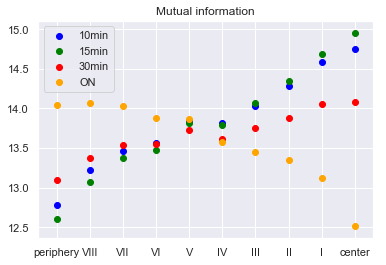

In [63]:
fig, ax = plt.subplots()
time = '10min'
y = [locals()['MI_layer'+str(centrality)+'_'+str(time)].sum() for centrality in range(1,11)]
ax.scatter(x=range(len(y)),y=y,color='blue',label='10min')

time = '15min'
y = [locals()['MI_layer'+str(centrality)+'_'+str(time)].sum() for centrality in range(1,11)]
ax.scatter(x=range(len(y)),y=y,color='green',label='15min')

time = '30min'
y = [locals()['MI_layer'+str(centrality)+'_'+str(time)].sum() for centrality in range(1,11)]
ax.scatter(x=range(len(y)),y=y,color='red',label='30min')

time = 'on'
y = [locals()['MI_layer'+str(centrality)+'_'+str(time)].sum() for centrality in range(1,11)]
ax.scatter(x=range(len(y)),y=y,color='orange',label='ON')

ax.set_xticks(range(0,10))
ax.set_xticklabels(["periphery","VIII","VII","VI","V","IV","III","II","I","center"])
ax.set_title('Mutual information')
plt.legend()
plt.savefig('MI_genome-wide.png')
